Todo : 
- implement UCB1
- check if there are other algorithms
- find good experiments to compare algorithms
- reproduce experiment of https://arxiv.org/pdf/1506.03271.pdf (Section 4)

3 algorithms : Exp3, Exp3.P, Exp3-IX

# Exp-3 algorithm
cf https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
    
    def sample(self, t):
        return self.rewards[t]

In [13]:
def exp3(MAB, T, gamma=0):
    """
    Exp3 algorithm as in Auer et al. (2001)
    MAB: list of arms from Arm class
    T: time horizon
    gamma: random jump parameter for Exp3.P, set to 0 for vanilla Exp3
    """
    
    reward_hist = []
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    weight_hist = np.zeros((T, K))
    
    for t in range(T):
        p = (1-gamma)*W/np.sum(W) + gamma/K # set probabilities of drawing each arm
        drawn_index = np.where(np.random.multinomial(n=1, pvals=p))[0][0] # draw arm index
        drawn_reward = MAB[drawn_index].sample(t) # corresponding reward
        estimated_reward = drawn_reward/p[drawn_index] # compute estimated reward
        W[drawn_index] *= np.exp(gamma*estimated_reward/K) # update weights
        reward_hist.append(drawn_reward) # retrain reward
        weight_hist[t, :] = W
        
    return reward_hist, weight_hist

In [14]:
def exp3_IX(MAB, T, eta, gamma):
    """
    Exp3-IX algorithm as in Explore no more (Neu)
    MAB: list of arms from Arm class
    T: the time horizon
    eta: 
    gamma: random jump parameter
    """
    reward_hist = []
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    weight_hist = np.zeros((T, K))
    
    for t in range(T):
        p = W/np.sum(W) # set probabilities of drawing each arm
        
        drawn_index = np.where(np.random.multinomial(n=1, pvals=p))[0][0] # draw arm index
        
        drawn_reward = MAB[drawn_index].sample(t) # corresponding reward
        
        # compute estimated reward with implicit exploration
        estimated_reward = drawn_reward/(p[drawn_index] + gamma) 
        
        W[drawn_index] *= np.exp(eta*estimated_reward) # update weights
        
        reward_hist.append(drawn_reward) # retrain reward
        
        weight_hist[t, :] = W
        
    return reward_hist, weight_hist

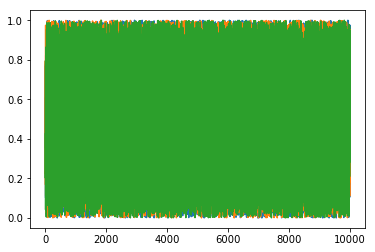

In [71]:
# 3 arms bandit, the reward of each arm is distributed as a uniform over [0, 1]
# Not a good example, too noisy -> picking arm uniformly at random should perform well
# Need to add a bit of structure...

T = 10000
arm1 = Arm(np.random.uniform(0, 1, T))
arm2 = Arm(np.random.uniform(0, 1, T)) 
arm3 = Arm(np.random.uniform(0, 1, T)) 

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)

In [72]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

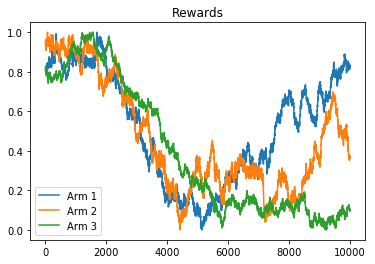

In [84]:
T = 10000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

In [85]:
rew, _ = exp3(MAB, T)
rew_P, _ = exp3(MAB, T, gamma=0.1)
rew_IX, _ = exp3_IX(MAB, T, 0.1, 0.1)

arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)

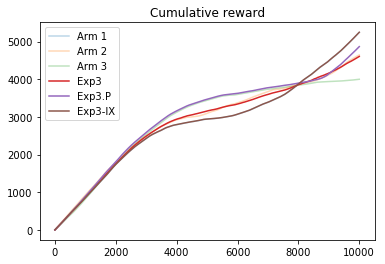

In [86]:
plt.plot(np.cumsum(arm1.rewards), alpha=0.3)
plt.plot(np.cumsum(arm2.rewards), alpha=0.3)
plt.plot(np.cumsum(arm3.rewards), alpha=0.3)
plt.plot(exp3_cumsum)
plt.plot(exp3_P_cumsum)
plt.plot(exp3_IX_cumsum)

plt.legend(['Arm 1', 'Arm 2', 'Arm 3', 'Exp3', 'Exp3.P', 'Exp3-IX'])
plt.title("Cumulative reward")

In [87]:
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

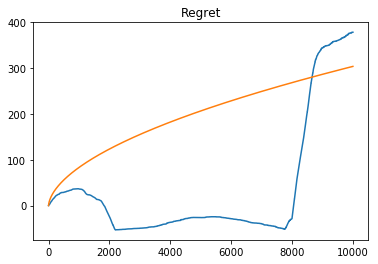

In [88]:
plt.plot(best_action_rew - exp3_P_cumsum)
plt.title('Regret')

lin = [np.sqrt(t*log(t)) for t in range(1, T)]
plt.plot(lin) 